In [87]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Thu Apr  7 21:11:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 21%   52C    P2   132W / 250W |   4882MiB / 11019MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [4]:
! kill -9 411110

In [5]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 0
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [7]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [8]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local1_folder_temp.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

Inception-Copy1.ipynb
Inception.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal.ipynb
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt16_fc_1e-3_1_nofreeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3_1.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-3_freeze_specificlayer.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-4_freeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_f1_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_f1

# Data preprocessing

## Image data

In [9]:
data_zip = zipfile.ZipFile(data_zip_file)

In [10]:
# data_zip2 = zipfile.ZipFile(data_zip_file2)

In [11]:
len(data_zip.namelist())

58766

In [12]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7FBDB226C820>
(734, 800, 3)


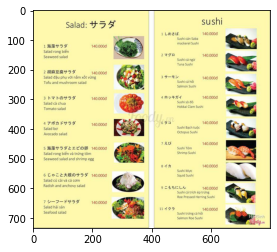

In [13]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [14]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [15]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [16]:
data_df4.shape

(3093, 11)

In [17]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [18]:
data_df.shape

(14174, 11)

In [19]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [20]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [21]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [23]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 6.0) & (data_df['score'] <= 6.5)][['Comment','score']].sort_values(by=['score'])

,Comment,score
15,Mình gọi 1 combo 2 bánh: bánh mì tổ dân phố và...,6.0
7869,Vị trí: nếu không ở quanh quanh khu chắc k biế...,6.0
7825,Mình order trà sữa KHÔNG đường nhưng ngọt quá ...,6.0
7758,"Quán chỉ có mỗi bún sườn mọc hoặc mọc ko thôi,...",6.0
7705,Ăn miếng đầu tiên thấy khá là thơm. Cũng ngon ...,6.0
...,...,...
8763,Quán khá hay. Mình đến sớm nên nhân viên cũng ...,6.4
8742,May đặt trước nên còn bàn chứ đến thấy full hế...,6.4
8687,Mình ăn 1 suất phở chín! Giá 35k\nQuán khá sạc...,6.4
8916,"Bò Úc nướng kèm cheese nhiều cheese, thịt mềm....",6.4


In [24]:
data_df['Comment'][15]

'Mình gọi 1 combo 2 bánh: bánh mì tổ dân phố và bánh mì tổ phó chân giò hun khói. Tổ dân phố toàn nộm còn tổ phó hầu như ko thấy pate đâu... sốt cũng ko có gì đặc biệt\nCombo 2 bánh 40k (ko up size), đặt qua now chắc đắt hơn mua tại quán (giá trên bao bì là 17k)'

In [25]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

1    6953
2    4194
0    3023
Name: label, dtype: int64


<AxesSubplot:>

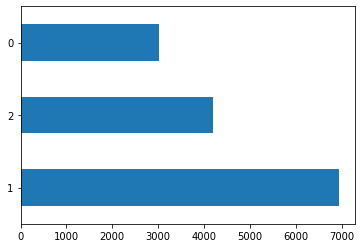

In [26]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [27]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [28]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [29]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [30]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [31]:
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    1
score         0
label         0
dtype: int64

In [32]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

In [33]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0


1    6952
2    4194
0    3023
Name: label, dtype: int64


<AxesSubplot:>

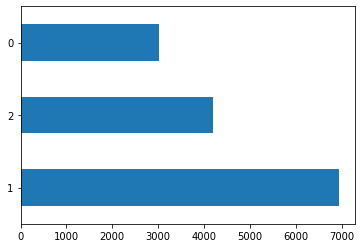

In [34]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [35]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [36]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [37]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [38]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(12, 8)

In [39]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    chưa bao_giờ phải đăng_nhập để bình_luận về đồ...
4188    ko biết các mẹ đặt ntn nhưng hnay em có gọi su...
4189    hôm_nay mình có vc ko đi ra ngoài ăn đc nên mì...
4190    món iberico cắt từ đùi heo tại bàn đặc_sản của...
Name: preprocess_comment, dtype: object

In [40]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

195      1
558      1
714      1
1102     1
1168     1
1452     1
1556     1
1629     1
2200     1
2503     1
2535     1
2642     1
2687     1
3158     1
3163     1
3216     1
3314     1
3510     1
3964     1
3989     1
4021     1
4179     1
4420     1
4903     1
5103     1
6020     1
6128     1
6423     1
6727     1
7239     1
7641     1
7791     1
8273     1
8872     1
9089     1
9432     1
10199    1
10499    1
10559    1
10825    1
11079    1
12357    1
12619    1
13333    1
13540    1
13930    1
Name: preprocess_comment, dtype: int64

In [41]:
a

0         56
1         43
2         38
3         34
4         74
        ... 
14164    107
14165    185
14166     17
14167    319
14168    133
Name: preprocess_comment, Length: 14169, dtype: int64

In [42]:
data_df['Comment'][195]

'Ổn'

<AxesSubplot:>

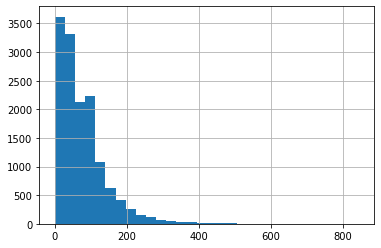

In [43]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

# Load BPE, Vocab of PhoBERT and DataGen

In [44]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    imgs.extend(bt[0])
    img_len.append(len(bt[0]))
    labels.append(bt[1])

  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  imgs_torch, img_len, labels

In [46]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    
    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return ( img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 16, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([224, 224]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
      ])
      val_transform = T.Compose([
        T.Resize([224, 224]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([224, 224]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [47]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0].shape)
    print(bat[1])
    print(len(bat[2]))

1    6952
2    4194
0    3023
Name: label, dtype: int64
1    5562
2    3355
0    2418
Name: label, dtype: int64
1    695
2    419
0    303
Name: label, dtype: int64
1    695
2    420
0    302
Name: label, dtype: int64
0
torch.Size([27, 3, 224, 224])
[2, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 6, 1, 1]
16


In [48]:
bat[1]

[1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4]

In [77]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda:1



In [50]:
len(data_df)

14169

# PhoBERT

In [51]:
# from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
# from transformers import RobertaForSequenceClassification

# pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
# pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [52]:
# class Bert_Lstm(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

#     self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
#   def forward(self, texts):
#     bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
#     bert_out = bert_out['last_hidden_state']
#     out, _ = self.lstm(bert_out)
#     feature_extract = out[:,-1,:].contiguous()

#     return feature_extract

In [53]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [54]:
from torchvision.models import inception_v3, resnet50, resnet34

In [55]:
# res = resnet50(pretrained = True,progress = True)
# res

In [56]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
#     self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
    self.res = resnet34(pretrained = True,progress = True)
    self.res_sequen = nn.Sequential(*list(self.res.children())[:-1])
#     self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#     self.drop = nn.Dropout(p=0.4)
#     self.flat
#     self.flat = nn.Linear(2048, 128)
#     self.cl = nn.Linear(2048,3)
#     self.ffn = nn.Sequential(
#             nn.Linear(2048, 128),
#             nn.ReLU(),
# #             nn.Dropout(0.3),
# #             nn.Linear(512, 128),
# #             nn.ReLU(),
# #             nn.Dropout(0.2),
#             nn.Linear(128, 3),
#         )
    self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 3)
        )

  def process(self, feature, len_img_list):
    max_fea = torch.zeros(len(len_img_list), 512).to(device)
    start = 0
    for idx, num in enumerate(len_img_list):
      max_fea[idx] = feature[start:start+num].max(0)[0]
      start += num

    return max_fea
  

  def forward(self, image, len_img_list):
    feature = self.res_sequen(image)
#     print(feature.shape)
#     feature = self.process(feature, len_img_list)
#     print(feature.shape)
#     feature = self.avgpool(feature)
#     print(feature.shape)
#     feature = self.drop(feature)
#     print(feature.shape)

    img_fea = feature.reshape(-1, 512)
    feature = self.process(img_fea, len_img_list)

#     img_fea = feature.contiguous().view(-1, 2048)
    # out = self.avgpool(feature)
    # out = out.contiguous().view(-1, 2048)
#     out = self.process(img_fea, len_img_list)
    logits = self.classifier(feature)
#     logits = self.cl(img_fea)
    
    return logits

In [57]:
# test_mod = Inception()
# test_mod.to(device)
# i1 = bat[0].to(device)
# # i2 = bat[1].to(device)
# ot = test_mod(i1, bat[1])

In [58]:
# ot.shape

In [59]:
# mod = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc = nn.Sequential(*list(mod.children())[:-1])
# inc

In [60]:
# a = torch.rand(16, 3,299,299)
# ot = inc(a)
# ot.shape

In [61]:
# test = Inception()
# ot = test(a)

In [62]:
# !pip install tensorflow

In [63]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [64]:
# !pip install tensorflow

In [65]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [66]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [67]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [68]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [69]:
# class Concatmodal(nn.Module):
#   def __init__(self):
#     super(Concatmodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
  
#   def forward(self, image, inputs, len_img_list, labels=None):
#     for key in inputs:
#         inputs[key] = inputs[key].to(device)
#     image = image.to(device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image, len_img_list)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out


In [70]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100

  counter = 0
  # total = 0

  model.train()

  soft_m = nn.Softmax(dim=-1)
  train_preds = np.array([])
  train_labels = np.array([])

  for i, (images, len_img_list, labels) in enumerate(tqdm(dm.train_dataloader())):
      counter += 1
      labels = labels.to(device)
      images = images.to(device)
    
      optimizer.zero_grad()
    
      outputs = model(images, len_img_list)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']

  return train_loss, train_ac

In [71]:
# b = torch.rand(1,3, requires_grad=True)
# print(b.requires_grad)

In [72]:
# m = torch.argmax(b, dim=-1)
# print(m.requires_grad)

In [73]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
#   val_preds = torch.tensor([], device=device)
#   val_labels = torch.tensor([], device = device)
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)
        images = images.to(device)

        outputs = model(images, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)
        
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
#         output_scores = output_scores.cpu().numpy()

        val_running_loss += loss.item()
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    
#   val_preds = val_preds.cpu().numpy()
#   val_labels = val_labels.cpu().numpy()

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


  return val_loss, val_ac


In [74]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, ( images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)
        images = images.to(device)

        outputs = model(images, inputs)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])

  # test_loss = test_running_loss / counter



In [75]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [76]:
# testing(mo, dm)

In [78]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [79]:
def save_checkpoint(state, filename='my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [80]:
%ls

Inception-Copy1.ipynb
Inception.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal.ipynb
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt16_fc_1e-3_1_nofreeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3_1.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-3_freeze_specificlayer.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-4_freeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_f1_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_f1

In [81]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [82]:
model = Inception()

In [85]:
def freeze(model):  
  # for param in model.BERT.PhoBERT.parameters():
  #   param.requires_grad = False
  for param in model.res_sequen.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.res_sequen.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [71]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [83]:
# model = Inception()
# model = freeze(model)
# model.to(device)

In [84]:
model

Inception(
  (res): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [15]:
for name, child in model.res_sequen.named_children():
    print(name)
#     if name in ['layer3', 'layer4']:
#         print(name + 'has been unfrozen.')
#         for param in child.parameters():
#             param.requires_grad = True
#     else:
#         for param in child.parameters():
#             param.requires_grad = False

0
1
2
3
4
5
6
7
8


In [86]:
model = freeze(model)
model.to(device)

Inception(
  (res): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [85]:
from torch.optim import lr_scheduler
import time

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]

#define model
# model = Concatmodal()
# model = freeze(model)
# model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 2e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 2e-5}
#     ], lr=3e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
epochs = 20
# lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
since = time.time()

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_epoch_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
#   lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print('Train acc', train_epoch_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_epoch_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'val_epoch_loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
testing(model, dm)

27,050,795 total parameters.
5,253,123 training parameters.
Epoch 0 of 20


 14%|█████▊                                   | 100/709 [00:46<04:55,  2.06it/s]

Epoch 0 Step 99 ave_loss 1.1864


 28%|███████████▌                             | 200/709 [01:29<03:25,  2.48it/s]

Epoch 0 Step 199 ave_loss 1.1004


 42%|█████████████████▎                       | 300/709 [02:09<02:53,  2.35it/s]

Epoch 0 Step 299 ave_loss 1.0727


 56%|███████████████████████▏                 | 400/709 [02:52<02:25,  2.13it/s]

Epoch 0 Step 399 ave_loss 1.0940


 71%|████████████████████████████▉            | 500/709 [03:37<01:32,  2.26it/s]

Epoch 0 Step 499 ave_loss 1.0908


 85%|██████████████████████████████████▋      | 600/709 [04:21<00:51,  2.13it/s]

Epoch 0 Step 599 ave_loss 1.0579


 99%|████████████████████████████████████████▍| 700/709 [05:06<00:04,  2.13it/s]

Epoch 0 Step 699 ave_loss 1.0496


100%|█████████████████████████████████████████| 709/709 [05:10<00:00,  2.29it/s]


[[ 998  604  816]
 [1351 1752 2459]
 [ 782 1057 1516]]
              precision    recall  f1-score   support

         0.0       0.70      0.15      0.25       303
         1.0       1.00      0.00      0.01       695
         2.0       0.31      0.99      0.47       419

    accuracy                           0.33      1417
   macro avg       0.67      0.38      0.24      1417
weighted avg       0.73      0.33      0.19      1417

[[ 46   0 257]
 [ 14   2 679]
 [  6   0 413]]
Train acc 0.3741098322723874
Train Loss: 1.0942
Val Loss: 1.0509
Val Acc: 0.2408
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 1 of 20


 14%|█████▊                                   | 100/709 [00:44<04:41,  2.17it/s]

Epoch 1 Step 99 ave_loss 1.0558


 28%|███████████▌                             | 200/709 [01:30<03:32,  2.39it/s]

Epoch 1 Step 199 ave_loss 1.0547


 42%|█████████████████▎                       | 300/709 [02:15<02:45,  2.48it/s]

Epoch 1 Step 299 ave_loss 1.0667


 56%|███████████████████████▏                 | 400/709 [03:00<02:12,  2.34it/s]

Epoch 1 Step 399 ave_loss 1.0516


 71%|████████████████████████████▉            | 500/709 [03:44<01:31,  2.29it/s]

Epoch 1 Step 499 ave_loss 1.0427


 85%|██████████████████████████████████▋      | 600/709 [04:28<00:40,  2.67it/s]

Epoch 1 Step 599 ave_loss 1.0409


 99%|████████████████████████████████████████▍| 700/709 [05:13<00:04,  2.09it/s]

Epoch 1 Step 699 ave_loss 1.0663


100%|█████████████████████████████████████████| 709/709 [05:16<00:00,  2.24it/s]


[[1176  587  655]
 [1271 2033 2258]
 [ 767 1104 1484]]


/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

         0.0       0.55      0.45      0.49       303
         1.0       0.53      0.89      0.67       695
         2.0       0.00      0.00      0.00       419

    accuracy                           0.53      1417
   macro avg       0.36      0.45      0.39      1417
weighted avg       0.38      0.53      0.43      1417

[[137 166   0]
 [ 74 621   0]
 [ 40 379   0]]
Train acc 0.4127820079225046
Train Loss: 1.0540
Val Loss: 1.0340
Val Acc: 0.3873
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 2 of 20


 14%|█████▊                                   | 100/709 [00:43<03:47,  2.67it/s]

Epoch 2 Step 99 ave_loss 1.0409


 28%|███████████▌                             | 200/709 [01:28<04:04,  2.08it/s]

Epoch 2 Step 199 ave_loss 1.0232


 42%|█████████████████▎                       | 300/709 [02:12<03:00,  2.26it/s]

Epoch 2 Step 299 ave_loss 1.0563


 56%|███████████████████████▏                 | 400/709 [02:55<02:19,  2.21it/s]

Epoch 2 Step 399 ave_loss 1.0464


 71%|████████████████████████████▉            | 500/709 [03:37<01:38,  2.12it/s]

Epoch 2 Step 499 ave_loss 1.0411


 85%|██████████████████████████████████▋      | 600/709 [04:21<00:47,  2.27it/s]

Epoch 2 Step 599 ave_loss 1.0432


 99%|████████████████████████████████████████▍| 700/709 [05:04<00:04,  2.01it/s]

Epoch 2 Step 699 ave_loss 1.0363


100%|█████████████████████████████████████████| 709/709 [05:08<00:00,  2.30it/s]


[[1210  582  626]
 [1232 2194 2136]
 [ 735 1138 1482]]
              precision    recall  f1-score   support

         0.0       0.57      0.40      0.47       303
         1.0       0.55      0.15      0.24       695
         2.0       0.34      0.83      0.49       419

    accuracy                           0.41      1417
   macro avg       0.49      0.46      0.40      1417
weighted avg       0.49      0.41      0.36      1417

[[121  47 135]
 [ 60 107 528]
 [ 31  40 348]]
Train acc 0.428548316848095
Train Loss: 1.0404
Val Loss: 1.0091
Val Acc: 0.3991
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 3 of 20


 14%|█████▊                                   | 100/709 [00:44<04:04,  2.49it/s]

Epoch 3 Step 99 ave_loss 1.0371


 28%|███████████▌                             | 200/709 [01:30<03:54,  2.17it/s]

Epoch 3 Step 199 ave_loss 1.0309


 42%|█████████████████▎                       | 300/709 [02:13<03:09,  2.16it/s]

Epoch 3 Step 299 ave_loss 1.0412


 56%|███████████████████████▏                 | 400/709 [02:57<02:31,  2.04it/s]

Epoch 3 Step 399 ave_loss 1.0410


 71%|████████████████████████████▉            | 500/709 [03:41<01:42,  2.03it/s]

Epoch 3 Step 499 ave_loss 1.0337


 85%|██████████████████████████████████▋      | 600/709 [04:25<00:47,  2.28it/s]

Epoch 3 Step 599 ave_loss 1.0379


 99%|████████████████████████████████████████▍| 700/709 [05:10<00:03,  2.34it/s]

Epoch 3 Step 699 ave_loss 1.0444


100%|█████████████████████████████████████████| 709/709 [05:14<00:00,  2.25it/s]


[[1212  567  639]
 [1255 2239 2068]
 [ 704 1112 1539]]
              precision    recall  f1-score   support

         0.0       0.37      0.76      0.50       303
         1.0       0.69      0.18      0.28       695
         2.0       0.39      0.58      0.47       419

    accuracy                           0.42      1417
   macro avg       0.48      0.50      0.42      1417
weighted avg       0.53      0.42      0.38      1417

[[229  19  55]
 [252 124 319]
 [140  37 242]]
INFO: Early stopping counter 1 of 5
Train acc 0.4370062193752364
Train Loss: 1.0381
Val Loss: 1.0182
Val Acc: 0.4156
Epoch 4 of 20


 14%|█████▊                                   | 100/709 [00:44<04:44,  2.14it/s]

Epoch 4 Step 99 ave_loss 1.0245


 28%|███████████▌                             | 200/709 [01:28<03:58,  2.14it/s]

Epoch 4 Step 199 ave_loss 1.0418


 42%|█████████████████▎                       | 300/709 [02:13<03:05,  2.20it/s]

Epoch 4 Step 299 ave_loss 1.0312


 56%|███████████████████████▏                 | 400/709 [02:59<02:11,  2.35it/s]

Epoch 4 Step 399 ave_loss 1.0395


 71%|████████████████████████████▉            | 500/709 [03:42<01:21,  2.57it/s]

Epoch 4 Step 499 ave_loss 1.0361


 85%|██████████████████████████████████▋      | 600/709 [04:23<00:44,  2.46it/s]

Epoch 4 Step 599 ave_loss 1.0294


 99%|████████████████████████████████████████▍| 700/709 [05:06<00:04,  2.04it/s]

Epoch 4 Step 699 ave_loss 1.0283


100%|█████████████████████████████████████████| 709/709 [05:10<00:00,  2.28it/s]


[[1214  623  581]
 [1208 2298 2056]
 [ 690 1166 1499]]
              precision    recall  f1-score   support

         0.0       0.43      0.68      0.52       303
         1.0       0.65      0.35      0.45       695
         2.0       0.42      0.56      0.48       419

    accuracy                           0.48      1417
   macro avg       0.50      0.53      0.48      1417
weighted avg       0.53      0.48      0.48      1417

[[206  48  49]
 [176 240 279]
 [102  81 236]]
Train acc 0.43853068455182714
Train Loss: 1.0325
Val Loss: 0.9921
Val Acc: 0.4849
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 5 of 20


 14%|█████▊                                   | 100/709 [00:40<04:15,  2.38it/s]

Epoch 5 Step 99 ave_loss 1.0195


 28%|███████████▌                             | 200/709 [01:24<03:45,  2.26it/s]

Epoch 5 Step 199 ave_loss 1.0373


 42%|█████████████████▎                       | 300/709 [02:08<02:40,  2.54it/s]

Epoch 5 Step 299 ave_loss 1.0302


 56%|███████████████████████▏                 | 400/709 [02:51<02:09,  2.39it/s]

Epoch 5 Step 399 ave_loss 1.0310


 71%|████████████████████████████▉            | 500/709 [03:38<01:25,  2.46it/s]

Epoch 5 Step 499 ave_loss 1.0351


 85%|██████████████████████████████████▋      | 600/709 [04:21<00:39,  2.76it/s]

Epoch 5 Step 599 ave_loss 1.0278


 99%|████████████████████████████████████████▍| 700/709 [05:04<00:03,  2.37it/s]

Epoch 5 Step 699 ave_loss 1.0187


100%|█████████████████████████████████████████| 709/709 [05:08<00:00,  2.30it/s]


[[1259  573  586]
 [1258 2289 2015]
 [ 695 1081 1579]]
              precision    recall  f1-score   support

         0.0       0.57      0.42      0.48       303
         1.0       0.54      0.87      0.67       695
         2.0       0.60      0.11      0.19       419

    accuracy                           0.55      1417
   macro avg       0.57      0.47      0.45      1417
weighted avg       0.57      0.55      0.49      1417

[[127 167   9]
 [ 65 608  22]
 [ 30 343  46]]
INFO: Early stopping counter 1 of 5
Train acc 0.4493329830982802
Train Loss: 1.0283
Val Loss: 1.0011
Val Acc: 0.4467
Epoch 6 of 20


 14%|█████▊                                   | 100/709 [00:44<05:03,  2.01it/s]

Epoch 6 Step 99 ave_loss 1.0101


 28%|███████████▌                             | 200/709 [01:28<03:25,  2.48it/s]

Epoch 6 Step 199 ave_loss 1.0306


 42%|█████████████████▎                       | 300/709 [02:09<03:07,  2.18it/s]

Epoch 6 Step 299 ave_loss 1.0350


 56%|███████████████████████▏                 | 400/709 [02:52<02:10,  2.36it/s]

Epoch 6 Step 399 ave_loss 1.0416


 71%|████████████████████████████▉            | 500/709 [03:37<01:29,  2.34it/s]

Epoch 6 Step 499 ave_loss 1.0091


 85%|██████████████████████████████████▋      | 600/709 [04:22<00:47,  2.32it/s]

Epoch 6 Step 599 ave_loss 1.0297


 99%|████████████████████████████████████████▍| 700/709 [05:11<00:04,  1.87it/s]

Epoch 6 Step 699 ave_loss 1.0255


100%|█████████████████████████████████████████| 709/709 [05:15<00:00,  2.25it/s]


[[1246  639  533]
 [1211 2564 1787]
 [ 678 1182 1495]]
              precision    recall  f1-score   support

         0.0       0.57      0.46      0.51       303
         1.0       0.62      0.37      0.46       695
         2.0       0.39      0.69      0.50       419

    accuracy                           0.49      1417
   macro avg       0.52      0.51      0.49      1417
weighted avg       0.54      0.49      0.48      1417

[[140  70  93]
 [ 69 259 367]
 [ 37  92 290]]
INFO: Early stopping counter 2 of 5
Train acc 0.46043803185447224
Train Loss: 1.0260
Val Loss: 1.0072
Val Acc: 0.4901
Epoch 7 of 20


 14%|█████▊                                   | 100/709 [00:47<05:12,  1.95it/s]

Epoch 7 Step 99 ave_loss 1.0204


 28%|███████████▌                             | 200/709 [01:32<03:21,  2.52it/s]

Epoch 7 Step 199 ave_loss 1.0346


 42%|█████████████████▎                       | 300/709 [02:19<03:36,  1.89it/s]

Epoch 7 Step 299 ave_loss 1.0332


 56%|███████████████████████▏                 | 400/709 [03:05<02:37,  1.97it/s]

Epoch 7 Step 399 ave_loss 1.0079


 71%|████████████████████████████▉            | 500/709 [03:51<01:29,  2.34it/s]

Epoch 7 Step 499 ave_loss 1.0494


 85%|██████████████████████████████████▋      | 600/709 [04:40<00:55,  1.97it/s]

Epoch 7 Step 599 ave_loss 1.0141


 99%|████████████████████████████████████████▍| 700/709 [05:25<00:03,  2.34it/s]

Epoch 7 Step 699 ave_loss 1.0273


100%|█████████████████████████████████████████| 709/709 [05:30<00:00,  2.15it/s]


[[1220  672  526]
 [1207 2422 1933]
 [ 669 1126 1560]]
              precision    recall  f1-score   support

         0.0       0.50      0.56      0.53       303
         1.0       0.58      0.75      0.65       695
         2.0       0.53      0.23      0.32       419

    accuracy                           0.56      1417
   macro avg       0.54      0.51      0.50      1417
weighted avg       0.55      0.56      0.53      1417

[[169 113  21]
 [108 521  66]
 [ 59 263  97]]
Train acc 0.45360448308909773
Train Loss: 1.0260
Val Loss: 0.9921
Val Acc: 0.5017
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 8 of 20


 14%|█████▊                                   | 100/709 [00:46<04:45,  2.13it/s]

Epoch 8 Step 99 ave_loss 1.0135


 28%|███████████▌                             | 200/709 [01:34<03:48,  2.23it/s]

Epoch 8 Step 199 ave_loss 1.0072


 42%|█████████████████▎                       | 300/709 [02:20<03:14,  2.11it/s]

Epoch 8 Step 299 ave_loss 1.0214


 56%|███████████████████████▏                 | 400/709 [03:06<02:07,  2.42it/s]

Epoch 8 Step 399 ave_loss 1.0365


 71%|████████████████████████████▉            | 500/709 [03:54<01:37,  2.15it/s]

Epoch 8 Step 499 ave_loss 1.0161


 85%|██████████████████████████████████▋      | 600/709 [04:42<00:42,  2.56it/s]

Epoch 8 Step 599 ave_loss 1.0177


 99%|████████████████████████████████████████▍| 700/709 [05:29<00:04,  2.00it/s]

Epoch 8 Step 699 ave_loss 1.0323


100%|█████████████████████████████████████████| 709/709 [05:34<00:00,  2.12it/s]


[[1267  655  496]
 [1264 2536 1762]
 [ 701 1191 1463]]
              precision    recall  f1-score   support

         0.0       0.57      0.39      0.47       303
         1.0       0.66      0.12      0.20       695
         2.0       0.34      0.87      0.49       419

    accuracy                           0.40      1417
   macro avg       0.53      0.46      0.38      1417
weighted avg       0.55      0.40      0.34      1417

[[119  15 169]
 [ 61  83 551]
 [ 27  27 365]]
INFO: Early stopping counter 1 of 5
Train acc 0.4573541161577
Train Loss: 1.0208
Val Loss: 1.0135
Val Acc: 0.3848
Epoch 9 of 20


 14%|█████▊                                   | 100/709 [00:47<04:50,  2.09it/s]

Epoch 9 Step 99 ave_loss 1.0307


 28%|███████████▌                             | 200/709 [01:34<03:55,  2.16it/s]

Epoch 9 Step 199 ave_loss 1.0191


 42%|█████████████████▎                       | 300/709 [02:23<02:58,  2.29it/s]

Epoch 9 Step 299 ave_loss 1.0043


 56%|███████████████████████▏                 | 400/709 [03:07<01:46,  2.90it/s]

Epoch 9 Step 399 ave_loss 0.9963


 71%|████████████████████████████▉            | 500/709 [03:53<01:36,  2.16it/s]

Epoch 9 Step 499 ave_loss 1.0292


 85%|██████████████████████████████████▋      | 600/709 [04:35<00:40,  2.68it/s]

Epoch 9 Step 599 ave_loss 1.0171


 99%|████████████████████████████████████████▍| 700/709 [05:21<00:04,  2.19it/s]

Epoch 9 Step 699 ave_loss 1.0237


100%|█████████████████████████████████████████| 709/709 [05:25<00:00,  2.18it/s]


[[1284  620  514]
 [1223 2546 1793]
 [ 705 1103 1547]]
              precision    recall  f1-score   support

         0.0       0.62      0.33      0.43       303
         1.0       0.60      0.55      0.58       695
         2.0       0.42      0.61      0.50       419

    accuracy                           0.52      1417
   macro avg       0.55      0.50      0.50      1417
weighted avg       0.55      0.52      0.52      1417

[[ 99 113  91]
 [ 41 385 269]
 [ 20 142 257]]
INFO: Early stopping counter 2 of 5
Train acc 0.4677556796815418
Train Loss: 1.0171
Val Loss: 1.0090
Val Acc: 0.5002
Epoch 10 of 20


 14%|█████▊                                   | 100/709 [00:48<04:31,  2.24it/s]

Epoch 10 Step 99 ave_loss 1.0214


 28%|███████████▌                             | 200/709 [01:35<03:55,  2.16it/s]

Epoch 10 Step 199 ave_loss 1.0251


 42%|█████████████████▎                       | 300/709 [02:22<03:28,  1.96it/s]

Epoch 10 Step 299 ave_loss 1.0223


 56%|███████████████████████▏                 | 400/709 [03:08<02:21,  2.19it/s]

Epoch 10 Step 399 ave_loss 1.0223


 71%|████████████████████████████▉            | 500/709 [03:53<01:40,  2.08it/s]

Epoch 10 Step 499 ave_loss 1.0275


 85%|██████████████████████████████████▋      | 600/709 [04:42<00:59,  1.82it/s]

Epoch 10 Step 599 ave_loss 1.0027


 99%|████████████████████████████████████████▍| 700/709 [05:28<00:03,  2.29it/s]

Epoch 10 Step 699 ave_loss 1.0149


100%|█████████████████████████████████████████| 709/709 [05:32<00:00,  2.13it/s]


[[1288  662  468]
 [1190 2674 1698]
 [ 714 1202 1439]]
              precision    recall  f1-score   support

         0.0       0.49      0.56      0.52       303
         1.0       0.64      0.44      0.52       695
         2.0       0.42      0.59      0.49       419

    accuracy                           0.51      1417
   macro avg       0.52      0.53      0.51      1417
weighted avg       0.54      0.51      0.51      1417

[[171  69  63]
 [115 307 273]
 [ 64 107 248]]
Train acc 0.4673969110907034
Train Loss: 1.0183
Val Loss: 0.9853
Val Acc: 0.5132
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 11 of 20


 14%|█████▊                                   | 100/709 [00:46<04:24,  2.31it/s]

Epoch 11 Step 99 ave_loss 1.0107


 28%|███████████▌                             | 200/709 [01:31<03:50,  2.21it/s]

Epoch 11 Step 199 ave_loss 1.0232


 42%|█████████████████▎                       | 300/709 [02:16<03:03,  2.23it/s]

Epoch 11 Step 299 ave_loss 1.0272


 56%|███████████████████████▏                 | 400/709 [03:01<02:17,  2.24it/s]

Epoch 11 Step 399 ave_loss 0.9964


 71%|████████████████████████████▉            | 500/709 [03:50<01:45,  1.98it/s]

Epoch 11 Step 499 ave_loss 1.0101


 85%|██████████████████████████████████▋      | 600/709 [04:37<00:50,  2.16it/s]

Epoch 11 Step 599 ave_loss 1.0058


 99%|████████████████████████████████████████▍| 700/709 [05:24<00:04,  2.01it/s]

Epoch 11 Step 699 ave_loss 1.0271


100%|█████████████████████████████████████████| 709/709 [05:28<00:00,  2.16it/s]


[[1308  638  472]
 [1267 2495 1800]
 [ 711 1098 1546]]
              precision    recall  f1-score   support

         0.0       0.48      0.58      0.53       303
         1.0       0.61      0.56      0.58       695
         2.0       0.48      0.46      0.47       419

    accuracy                           0.54      1417
   macro avg       0.52      0.53      0.53      1417
weighted avg       0.54      0.54      0.54      1417

[[176  95  32]
 [123 391 181]
 [ 67 159 193]]
INFO: Early stopping counter 1 of 5
Train acc 0.4664113616395406
Train Loss: 1.0141
Val Loss: 0.9924
Val Acc: 0.5259
Epoch 12 of 20


 14%|█████▊                                   | 100/709 [00:46<05:21,  1.89it/s]

Epoch 12 Step 99 ave_loss 1.0233


 28%|███████████▌                             | 200/709 [01:33<04:16,  1.99it/s]

Epoch 12 Step 199 ave_loss 1.0146


 42%|█████████████████▎                       | 300/709 [02:22<03:47,  1.80it/s]

Epoch 12 Step 299 ave_loss 1.0174


 56%|███████████████████████▏                 | 400/709 [03:08<02:21,  2.18it/s]

Epoch 12 Step 399 ave_loss 1.0167


 71%|████████████████████████████▉            | 500/709 [03:55<01:42,  2.04it/s]

Epoch 12 Step 499 ave_loss 1.0171


 85%|██████████████████████████████████▋      | 600/709 [04:41<00:51,  2.11it/s]

Epoch 12 Step 599 ave_loss 1.0050


 99%|████████████████████████████████████████▍| 700/709 [05:29<00:04,  1.96it/s]

Epoch 12 Step 699 ave_loss 1.0033


100%|█████████████████████████████████████████| 709/709 [05:33<00:00,  2.13it/s]


[[1331  641  446]
 [1267 2610 1685]
 [ 692 1211 1452]]
              precision    recall  f1-score   support

         0.0       0.58      0.43      0.49       303
         1.0       0.59      0.66      0.63       695
         2.0       0.46      0.46      0.46       419

    accuracy                           0.55      1417
   macro avg       0.54      0.51      0.52      1417
weighted avg       0.55      0.55      0.55      1417

[[129 120  54]
 [ 64 461 170]
 [ 29 199 191]]
Train acc 0.4685592088697889
Train Loss: 1.0137
Val Loss: 0.9832
Val Acc: 0.5248
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 13 of 20


 14%|█████▊                                   | 100/709 [00:45<04:39,  2.18it/s]

Epoch 13 Step 99 ave_loss 1.0202


 28%|███████████▌                             | 200/709 [01:34<03:41,  2.30it/s]

Epoch 13 Step 199 ave_loss 1.0138


 42%|█████████████████▎                       | 300/709 [02:22<03:09,  2.16it/s]

Epoch 13 Step 299 ave_loss 1.0131


 56%|███████████████████████▏                 | 400/709 [03:10<02:45,  1.87it/s]

Epoch 13 Step 399 ave_loss 1.0126


 71%|████████████████████████████▉            | 500/709 [03:56<01:16,  2.74it/s]

Epoch 13 Step 499 ave_loss 1.0266


 85%|██████████████████████████████████▋      | 600/709 [04:41<00:47,  2.31it/s]

Epoch 13 Step 599 ave_loss 1.0147


 99%|████████████████████████████████████████▍| 700/709 [05:28<00:04,  2.01it/s]

Epoch 13 Step 699 ave_loss 1.0103


100%|█████████████████████████████████████████| 709/709 [05:31<00:00,  2.14it/s]


[[1352  608  458]
 [1316 2511 1735]
 [ 721 1130 1504]]
              precision    recall  f1-score   support

         0.0       0.65      0.31      0.42       303
         1.0       0.63      0.28      0.39       695
         2.0       0.36      0.82      0.50       419

    accuracy                           0.45      1417
   macro avg       0.54      0.47      0.44      1417
weighted avg       0.55      0.45      0.43      1417

[[ 93  59 151]
 [ 34 198 463]
 [ 17  59 343]]
INFO: Early stopping counter 1 of 5
Train acc 0.46802166626110847
Train Loss: 1.0161
Val Loss: 1.0266
Val Acc: 0.4354
Epoch 14 of 20


 14%|█████▊                                   | 100/709 [00:44<03:45,  2.70it/s]

Epoch 14 Step 99 ave_loss 1.0253


 28%|███████████▌                             | 200/709 [01:31<04:46,  1.78it/s]

Epoch 14 Step 199 ave_loss 1.0182


 42%|█████████████████▎                       | 300/709 [02:19<02:47,  2.45it/s]

Epoch 14 Step 299 ave_loss 1.0076


 56%|███████████████████████▏                 | 400/709 [03:08<03:04,  1.67it/s]

Epoch 14 Step 399 ave_loss 1.0090


 71%|████████████████████████████▉            | 500/709 [03:53<01:29,  2.33it/s]

Epoch 14 Step 499 ave_loss 1.0084


 85%|██████████████████████████████████▋      | 600/709 [04:41<00:56,  1.94it/s]

Epoch 14 Step 599 ave_loss 1.0064


 99%|████████████████████████████████████████▍| 700/709 [05:28<00:03,  2.62it/s]

Epoch 14 Step 699 ave_loss 1.0168


100%|█████████████████████████████████████████| 709/709 [05:32<00:00,  2.13it/s]


[[1333  597  488]
 [1288 2458 1816]
 [ 727 1059 1569]]
              precision    recall  f1-score   support

         0.0       0.47      0.61      0.53       303
         1.0       0.63      0.57      0.60       695
         2.0       0.46      0.44      0.45       419

    accuracy                           0.54      1417
   macro avg       0.52      0.54      0.53      1417
weighted avg       0.55      0.54      0.54      1417

[[185  76  42]
 [129 396 170]
 [ 77 158 184]]
Train acc 0.46819058846784545
Train Loss: 1.0119
Val Loss: 0.9715
Val Acc: 0.5275
Better ver saved
Saving....my_checkpoint_resnet34_seed0_bt16_fc_5e-4.pth.tar
Epoch 15 of 20


 14%|█████▊                                   | 100/709 [00:47<04:38,  2.19it/s]

Epoch 15 Step 99 ave_loss 1.0102


 28%|███████████▌                             | 200/709 [01:32<03:55,  2.16it/s]

Epoch 15 Step 199 ave_loss 1.0348


 42%|█████████████████▎                       | 300/709 [02:18<02:42,  2.51it/s]

Epoch 15 Step 299 ave_loss 0.9957


 56%|███████████████████████▏                 | 400/709 [03:03<02:05,  2.46it/s]

Epoch 15 Step 399 ave_loss 1.0186


 71%|████████████████████████████▉            | 500/709 [03:49<01:45,  1.97it/s]

Epoch 15 Step 499 ave_loss 1.0150


 85%|██████████████████████████████████▋      | 600/709 [04:36<00:53,  2.02it/s]

Epoch 15 Step 599 ave_loss 1.0162


 99%|████████████████████████████████████████▍| 700/709 [05:20<00:04,  2.14it/s]

Epoch 15 Step 699 ave_loss 0.9835


100%|█████████████████████████████████████████| 709/709 [05:24<00:00,  2.18it/s]


[[1376  561  481]
 [1400 2430 1732]
 [ 742 1075 1538]]
              precision    recall  f1-score   support

         0.0       0.41      0.67      0.51       303
         1.0       0.67      0.31      0.42       695
         2.0       0.41      0.58      0.48       419

    accuracy                           0.47      1417
   macro avg       0.49      0.52      0.47      1417
weighted avg       0.54      0.47      0.46      1417

[[203  40  60]
 [185 216 294]
 [107  68 244]]
INFO: Early stopping counter 1 of 5
Train acc 0.4670877397914874
Train Loss: 1.0107
Val Loss: 0.9724
Val Acc: 0.4709
Epoch 16 of 20


 14%|█████▊                                   | 100/709 [00:45<05:13,  1.94it/s]

Epoch 16 Step 99 ave_loss 1.0346


 28%|███████████▌                             | 200/709 [01:29<03:57,  2.15it/s]

Epoch 16 Step 199 ave_loss 1.0082


 42%|█████████████████▎                       | 300/709 [02:13<03:37,  1.88it/s]

Epoch 16 Step 299 ave_loss 1.0151


 56%|███████████████████████▏                 | 400/709 [02:58<02:25,  2.13it/s]

Epoch 16 Step 399 ave_loss 1.0100


 71%|████████████████████████████▉            | 500/709 [03:45<01:28,  2.37it/s]

Epoch 16 Step 499 ave_loss 1.0119


 85%|██████████████████████████████████▋      | 600/709 [04:33<00:59,  1.82it/s]

Epoch 16 Step 599 ave_loss 1.0175


 99%|████████████████████████████████████████▍| 700/709 [05:18<00:04,  2.14it/s]

Epoch 16 Step 699 ave_loss 1.0155


100%|█████████████████████████████████████████| 709/709 [05:22<00:00,  2.20it/s]


[[1354  589  475]
 [1334 2642 1586]
 [ 750 1168 1437]]
              precision    recall  f1-score   support

         0.0       0.46      0.57      0.51       303
         1.0       0.67      0.23      0.35       695
         2.0       0.37      0.71      0.49       419

    accuracy                           0.45      1417
   macro avg       0.50      0.51      0.45      1417
weighted avg       0.54      0.45      0.42      1417

[[173  30 100]
 [132 163 400]
 [ 71  50 298]]
INFO: Early stopping counter 2 of 5
Train acc 0.47075963228483525
Train Loss: 1.0158
Val Loss: 0.9865
Val Acc: 0.4489
Epoch 17 of 20


 14%|█████▊                                   | 100/709 [00:44<04:31,  2.24it/s]

Epoch 17 Step 99 ave_loss 1.0001


 28%|███████████▌                             | 200/709 [01:30<03:45,  2.26it/s]

Epoch 17 Step 199 ave_loss 1.0057


 42%|█████████████████▎                       | 300/709 [02:19<03:35,  1.89it/s]

Epoch 17 Step 299 ave_loss 1.0314


 56%|███████████████████████▏                 | 400/709 [03:06<02:51,  1.80it/s]

Epoch 17 Step 399 ave_loss 1.0193


 71%|████████████████████████████▉            | 500/709 [03:48<01:31,  2.28it/s]

Epoch 17 Step 499 ave_loss 1.0066


 85%|██████████████████████████████████▋      | 600/709 [04:36<00:50,  2.18it/s]

Epoch 17 Step 599 ave_loss 0.9942


 99%|████████████████████████████████████████▍| 700/709 [05:21<00:03,  2.42it/s]

Epoch 17 Step 699 ave_loss 1.0187


100%|█████████████████████████████████████████| 709/709 [05:25<00:00,  2.18it/s]


[[1381  602  435]
 [1268 2626 1668]
 [ 719 1117 1519]]
              precision    recall  f1-score   support

         0.0       0.60      0.45      0.51       303
         1.0       0.55      0.84      0.67       695
         2.0       0.51      0.17      0.26       419

    accuracy                           0.56      1417
   macro avg       0.55      0.49      0.48      1417
weighted avg       0.55      0.56      0.51      1417

[[135 150  18]
 [ 61 581  53]
 [ 29 317  73]]
INFO: Early stopping counter 3 of 5
Train acc 0.48097335153154314
Train Loss: 1.0106
Val Loss: 0.9903
Val Acc: 0.4791
Epoch 18 of 20


 14%|█████▊                                   | 100/709 [00:47<04:33,  2.22it/s]

Epoch 18 Step 99 ave_loss 1.0042


 28%|███████████▌                             | 200/709 [01:36<04:26,  1.91it/s]

Epoch 18 Step 199 ave_loss 1.0125


 42%|█████████████████▎                       | 300/709 [02:22<02:57,  2.31it/s]

Epoch 18 Step 299 ave_loss 1.0229


 56%|███████████████████████▏                 | 400/709 [03:09<02:36,  1.98it/s]

Epoch 18 Step 399 ave_loss 1.0039


 71%|████████████████████████████▉            | 500/709 [03:56<01:31,  2.29it/s]

Epoch 18 Step 499 ave_loss 0.9901


 85%|██████████████████████████████████▋      | 600/709 [04:42<00:42,  2.57it/s]

Epoch 18 Step 599 ave_loss 1.0219


 99%|████████████████████████████████████████▍| 700/709 [05:30<00:04,  2.12it/s]

Epoch 18 Step 699 ave_loss 0.9998


100%|█████████████████████████████████████████| 709/709 [05:34<00:00,  2.12it/s]


[[1350  636  432]
 [1251 2677 1634]
 [ 750 1167 1438]]
              precision    recall  f1-score   support

         0.0       0.52      0.49      0.51       303
         1.0       0.59      0.54      0.57       695
         2.0       0.43      0.50      0.46       419

    accuracy                           0.52      1417
   macro avg       0.51      0.51      0.51      1417
weighted avg       0.53      0.52      0.52      1417

[[149  95  59]
 [ 91 378 226]
 [ 45 163 211]]
INFO: Early stopping counter 4 of 5
Train acc 0.47349418370432333
Train Loss: 1.0081
Val Loss: 0.9757
Val Acc: 0.5120
Epoch 19 of 20


 14%|█████▊                                   | 100/709 [00:45<04:51,  2.09it/s]

Epoch 19 Step 99 ave_loss 1.0029


 28%|███████████▌                             | 200/709 [01:32<04:34,  1.85it/s]

Epoch 19 Step 199 ave_loss 1.0171


 42%|█████████████████▎                       | 300/709 [02:22<02:46,  2.45it/s]

Epoch 19 Step 299 ave_loss 1.0117


 56%|███████████████████████▏                 | 400/709 [03:07<02:24,  2.13it/s]

Epoch 19 Step 399 ave_loss 1.0130


 71%|████████████████████████████▉            | 500/709 [03:54<01:46,  1.95it/s]

Epoch 19 Step 499 ave_loss 1.0072


 85%|██████████████████████████████████▋      | 600/709 [04:39<00:46,  2.33it/s]

Epoch 19 Step 599 ave_loss 1.0038


 99%|████████████████████████████████████████▍| 700/709 [05:27<00:04,  2.00it/s]

Epoch 19 Step 699 ave_loss 1.0074


100%|█████████████████████████████████████████| 709/709 [05:31<00:00,  2.14it/s]


[[1371  602  445]
 [1361 2592 1609]
 [ 735 1142 1478]]
              precision    recall  f1-score   support

         0.0       0.46      0.61      0.52       303
         1.0       0.61      0.51      0.55       695
         2.0       0.44      0.46      0.45       419

    accuracy                           0.51      1417
   macro avg       0.50      0.52      0.51      1417
weighted avg       0.53      0.51      0.52      1417

[[184  76  43]
 [138 352 205]
 [ 79 147 193]]
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training complete in 120m 47s
test               precision    recall  f1-score   support

         0.0       0.46      0.52      0.49       302
         1.0       0.62      0.56      0.59       695
         2.0       0.47      0.50      0.49       420

    accuracy                           0.54      1417
   macro avg       0.52      0.53      0.52      1417
weighted avg       0.54      0.54      0.54      1417

test_ac 0.5356386732533521
Macro_f1 0.5220699

In [ ]:
# training(model, optimizer)
print(next(model.parameters()).device)

In [66]:
epochs = 10
# model = unfreeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'val_epoch_loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)

testing(model, dm)

159,621,451 total parameters.
788,611 training parameters.
Epoch 0 of 10
Epoch 0 Step 59 ave_loss 0.5513
Epoch 0 Step 119 ave_loss 0.5471
Epoch 0 Step 179 ave_loss 0.5584
Epoch 0 Step 239 ave_loss 0.5184
Epoch 0 Step 299 ave_loss 0.5201
Epoch 0 Step 359 ave_loss 0.5685
Epoch 0 Step 419 ave_loss 0.5234
Epoch 0 Step 479 ave_loss 0.5464
Epoch 0 Step 539 ave_loss 0.5545
Epoch 0 Step 599 ave_loss 0.5549
Epoch 0 Step 659 ave_loss 0.5650
Epoch 0 Step 719 ave_loss 0.5372
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       242
         1.0       0.77      0.87      0.82       551
         2.0       0.63      0.51      0.56       308

    accuracy                           0.75      1101
   macro avg       0.75      0.73      0.73      1101
weighted avg       0.75      0.75      0.75      1101

INFO: Early stopping counter 2 of 5
Train Loss: 0.5450
Val Loss: 0.5903
Val Acc: 0.7530
Epoch 1 of 10
Epoch 1 Step 59 ave_loss 0.5416
Epoch 1 Step 119 

In [78]:
import gc
del model 
gc.collect()

2329

In [79]:
torch.cuda.empty_cache()

In [80]:
!nvidia-smi

Tue Apr  5 16:00:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 38%   56C    P2   117W / 250W |   7759MiB / 11019MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
| 29%   

In [118]:
PATH = "my_checkpoint_resnet_seed0_bt16_fc_1e-3.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
# model = Concatmodal()
# model.load_state_dict(checkpoint['state_dict'])
model = Inception()
model.to(device)
print(checkpoint['epoch'])

10


In [119]:
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.21      0.45      0.29       302
         1.0       0.20      0.00      0.00       695
         2.0       0.30      0.55      0.38       420

    accuracy                           0.26      1417
   macro avg       0.24      0.33      0.23      1417
weighted avg       0.23      0.26      0.18      1417

test_ac 0.2582921665490473
Macro_f1 0.2252635342461161


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [68]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


